# ADZD Lab6 - Spark MLlib

## Setup

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
spark = SparkSession.builder.getOrCreate()

In [2]:
spark

## 1. Statistics (1p.)

Download the following dataset: https://www.kaggle.com/datasets/joebeachcapital/30000-spotify-songs

In [3]:
df = spark.read.csv("spotify_songs.csv", header=True, inferSchema=True)

#### Exercise 1.A

Show the first 10 rows of the dataset. What columns and what kind of data they contain? Hint: use show() method

In [4]:
for c in df.columns:
    print("column ", c)
    rows = df.select(c).take(10)
    for row in rows:
        print(row[c])
    print("\n")

column  track_id
6f807x0ima9a1j3VPbc7VN
0r7CVbZTWZgbTCYdfa2P31
1z1Hg7Vb0AhHDiEmnDE79l
75FpbthrwQmzHlBJLuGdC7
1e8PAfcKUYoKkxPhrHqw4x
7fvUMiyapMsRRxr07cU8Ef
2OAylPUDDfwRGfe0lYqlCQ
6b1RNvAcJjQH73eZO4BLAB
7bF6tCO3gFb8INrEDcjNT5
1IXGILkPm0tOCNeq00kCPa


column  track_name
I Don't Care (with Justin Bieber) - Loud Luxury Remix
Memories - Dillon Francis Remix
All the Time - Don Diablo Remix
Call You Mine - Keanu Silva Remix
Someone You Loved - Future Humans Remix
Beautiful People (feat. Khalid) - Jack Wins Remix
Never Really Over - R3HAB Remix
Post Malone (feat. RANI) - GATTÜSO Remix
Tough Love - Tiësto Remix / Radio Edit
If I Can't Have You - Gryffin Remix


column  track_artist
Ed Sheeran
Maroon 5
Zara Larsson
The Chainsmokers
Lewis Capaldi
Ed Sheeran
Katy Perry
Sam Feldt
Avicii
Shawn Mendes


column  track_popularity
66
67
70
60
69
67
62
69
68
67


column  track_album_id
2oCs0DGTsRO98Gh5ZSl2Cx
63rPSO264uRjW1X5E6cWv6
1HoSmj2eLcsrR0vE9gThr4
1nqYsOef1yKKuGOVchbsk6
7m7vv9wlQ4i0LFuJiE2zsQ
2yiy9c

### Descriptive statistics

#### Exercise 1.B

Calculate descriptive statistics for 'track_popularity' and 'duration_ms'  (see https://spark.apache.org/docs/1.6.1/api/java/org/apache/spark/sql/DataFrame.html#describe(scala.collection.Seq))

In [5]:
df.describe("track_popularity").show()
df.describe("duration_ms").show()


+-------+------------------+
|summary|  track_popularity|
+-------+------------------+
|  count|             32833|
|   mean|42.477080985593766|
| stddev|24.984074486186927|
|    min|                 0|
|    max|               100|
+-------+------------------+

+-------+------------------+
|summary|       duration_ms|
+-------+------------------+
|  count|             32833|
|   mean|225681.46748989128|
| stddev|  59936.5636225785|
|    min|            0.0116|
|    max|          517810.0|
+-------+------------------+



#### Exercise 1.C

Check if 'track_popularity' and 'duration_ms' have normal distribution (see http://spark.apache.org/docs/latest/api/java/org/apache/spark/ml/stat/KolmogorovSmirnovTest.html).

In [6]:
from pyspark.ml.stat import KolmogorovSmirnovTest

result = KolmogorovSmirnovTest.test(df, "track_popularity", "norm")
result.show()


result = KolmogorovSmirnovTest.test(df, "duration_ms", "norm")
result.show()


+--------------------+------------------+
|              pValue|         statistic|
+--------------------+------------------+
|7.408774704842358...|0.8870246032323421|
+--------------------+------------------+

+------+------------------+
|pValue|         statistic|
+------+------------------+
|   0.0|0.9999695428379983|
+------+------------------+



In [7]:
#Popularity could be normal, duration not likely

#### Exercise 1.D

Create correlation matrix between numeric values in the dataset. Which correlation is the strongest? Use the following, preprocessing function.

In [11]:
def preprocess_dataset(dataset):
    return (dataset
                .drop("track_id", "track_name", "track_artist", "track_album_id", "track_album_name", "track_album_release_date", "playlist_name", "playlist_id", "playlist_genre", "playlist_subgenre", "key")
                .withColumn("danceability", F.col("danceability").cast('double'))
                .withColumn("energy", F.col("energy").cast('double'))
                .withColumn("mode", F.col("mode").cast('double'))
                .withColumn("loudness", F.col("loudness").cast('double'))
            )

In [12]:
preprocessed = preprocess_dataset(df)
preprocessed = preprocessed.na.drop()


In [18]:
preprocessed.columns

['track_popularity',
 'danceability',
 'energy',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'duration_ms']

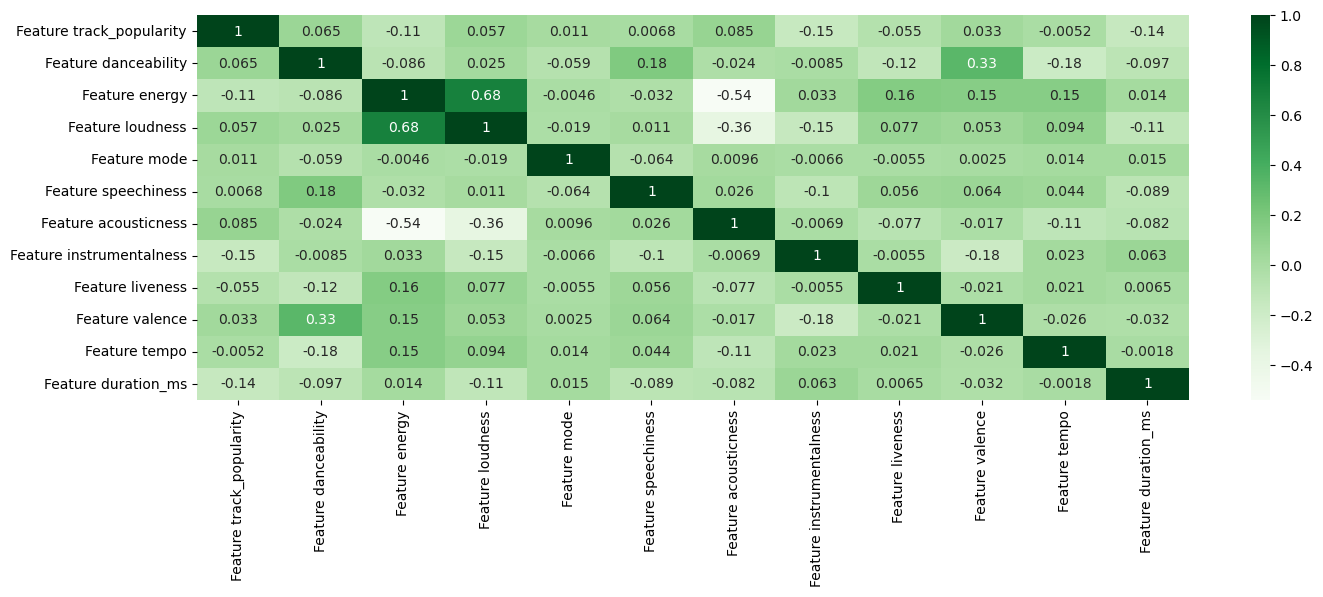

In [19]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler



assembler = VectorAssembler(inputCols=preprocessed.columns, outputCol="features")
vector_df = assembler.transform(preprocessed).select("features")

# Calculate the correlation matrix
matrix = Correlation.corr(vector_df, "features").head()[0]

import pandas as pd

# Assuming `matrix` is the DenseMatrix
matrix_df = pd.DataFrame(matrix.toArray())

# Optionally, set column names
matrix_df.columns = [f"Feature {preprocessed.columns[i]}" for i in range(matrix_df.shape[1])]

# Plot the heatmap
plt.figure(figsize=(16, 5))
sns.heatmap(matrix_df, xticklabels=matrix_df.columns, yticklabels=matrix_df.columns, cmap="Greens", annot=True)
plt.show()


In [ ]:
"""
energy + loudness
danceability + valence
speechiness + danceability
acousticness - energy - loudness
"""

## 2. Load Data

Doc: http://spark.apache.org/docs/latest/ml-datasource.html

Download data from https://github.com/apache/spark/blob/master/data/mllib/sample_libsvm_data.txt and load as DataFrame.

In [20]:
file = "sample_libsvm_data.txt"

df = spark.read.format("libsvm").option("numFeatures", "780").load(file)
df.show(10)
df.take(1)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(780,[127,128,129...|
|  1.0|(780,[158,159,160...|
|  1.0|(780,[124,125,126...|
|  1.0|(780,[152,153,154...|
|  1.0|(780,[151,152,153...|
|  0.0|(780,[129,130,131...|
|  1.0|(780,[158,159,160...|
|  1.0|(780,[99,100,101,...|
|  0.0|(780,[154,155,156...|
|  0.0|(780,[127,128,129...|
+-----+--------------------+
only showing top 10 rows



[Row(label=0.0, features=SparseVector(780, {127: 51.0, 128: 159.0, 129: 253.0, 130: 159.0, 131: 50.0, 154: 48.0, 155: 238.0, 156: 252.0, 157: 252.0, 158: 252.0, 159: 237.0, 181: 54.0, 182: 227.0, 183: 253.0, 184: 252.0, 185: 239.0, 186: 233.0, 187: 252.0, 188: 57.0, 189: 6.0, 207: 10.0, 208: 60.0, 209: 224.0, 210: 252.0, 211: 253.0, 212: 252.0, 213: 202.0, 214: 84.0, 215: 252.0, 216: 253.0, 217: 122.0, 235: 163.0, 236: 252.0, 237: 252.0, 238: 252.0, 239: 253.0, 240: 252.0, 241: 252.0, 242: 96.0, 243: 189.0, 244: 253.0, 245: 167.0, 262: 51.0, 263: 238.0, 264: 253.0, 265: 253.0, 266: 190.0, 267: 114.0, 268: 253.0, 269: 228.0, 270: 47.0, 271: 79.0, 272: 255.0, 273: 168.0, 289: 48.0, 290: 238.0, 291: 252.0, 292: 252.0, 293: 179.0, 294: 12.0, 295: 75.0, 296: 121.0, 297: 21.0, 300: 253.0, 301: 243.0, 302: 50.0, 316: 38.0, 317: 165.0, 318: 253.0, 319: 233.0, 320: 208.0, 321: 84.0, 328: 253.0, 329: 252.0, 330: 165.0, 343: 7.0, 344: 178.0, 345: 252.0, 346: 240.0, 347: 71.0, 348: 19.0, 349: 28.0

### Exercise 2.A

Load vehicle data from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/vehicle.scale 
Dataset description: http://archive.ics.uci.edu/ml/datasets/Vehicle

In [21]:
file = "vehicle.scale.txt"

vdata = spark.read.format("libsvm").option("numFeatures", "18").load(file)
vdata.show(10)
vdata.take(1)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  4.0|(18,[0,1,2,3,4,5,...|
|  4.0|(18,[0,1,2,3,4,5,...|
|  2.0|(18,[0,1,2,3,4,5,...|
|  4.0|(18,[0,1,2,3,4,5,...|
|  3.0|(18,[0,1,2,3,4,5,...|
|  3.0|(18,[0,1,2,3,4,5,...|
|  3.0|(18,[0,1,2,3,4,5,...|
|  4.0|(18,[0,1,2,3,4,5,...|
|  4.0|(18,[0,1,2,3,4,5,...|
|  2.0|(18,[0,1,2,3,4,5,...|
+-----+--------------------+
only showing top 10 rows



[Row(label=4.0, features=SparseVector(18, {0: -0.0435, 1: 0.1538, 2: 0.1944, 3: -0.3537, 4: -0.4505, 5: -0.6981, 6: -0.3464, 7: -0.0857, 8: -0.5, 9: 0.1714, 10: -0.5158, 11: -0.5324, 12: -0.0566, 13: -0.7105, 14: -0.4545, 15: -0.2195, 16: -0.2667, 17: 0.0667}))]

## 3. Classification (2.p)

### Exercise 3.A

Download Credit Card Fraud Detection Dataset 2023 from https://www.kaggle.com/datasets/nelgiriyewithana/credit-card-fraud-detection-dataset-2023 and make classification of potentially fraudulent transactions:

- Create pipeline with VectorAssembler and RandomForestClassifier.

- Use the pipeline to make predictions.

- Evaluate predictions using MulticlassClassificationEvaluator.

- Calculate accuracy and test error

- Print the structure of the trained decision tree (hint: use toDebugString attribute)

In [23]:
!pip install kagglehub
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nelgiriyewithana/credit-card-fraud-detection-dataset-2023")

print("Path to dataset files:", path)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 940.5 kB/s eta 0:00:000:00:01


100%|██████████| 143M/143M [00:06<00:00, 24.0MB/s] 

Extracting files...


Path to dataset files: /home/jovyan/.cache/kagglehub/datasets/nelgiriyewithana/credit-card-fraud-detection-dataset-2023/versions/1


In [25]:
fdetection = spark.read.csv(path, header=True, inferSchema=True)
fdetection.take(1)
print(fdetection.columns)

['id', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


In [26]:
print(fdetection.columns[:-1])

['id', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


In [29]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

train_data, test_data = fdetection.randomSplit([0.7, 0.3], seed=42)
assembler = VectorAssembler(inputCols= fdetection.columns[:-1] , outputCol="features")
rf_classifier = RandomForestClassifier(labelCol="Class", featuresCol="features", numTrees=10)
pipeline = Pipeline(stages=[assembler, rf_classifier])
model = pipeline.fit(train_data)
predictions = model.transform(test_data)
print(predictions.columns)

['id', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class', 'features', 'rawPrediction', 'probability', 'prediction']


In [30]:
evaluator = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
test_error = 1.0 - accuracy
print(f"Accuracy: {accuracy:.4f}")
print(f"Test Error: {test_error:.4f}")
rf_model = model.stages[-1]
print("Trained Random Forest model structure:")
print(rf_model.toDebugString)

Accuracy: 0.9981
Test Error: 0.0019
Trained Random Forest model structure:
RandomForestClassificationModel: uid=RandomForestClassifier_2b27641b5899, numTrees=10, numClasses=2, numFeatures=30
  Tree 0 (weight 1.0):
    If (feature 4 <= -0.02539201935598802)
     If (feature 14 <= -0.15100844808797703)
      If (feature 7 <= 0.45633312951761157)
       If (feature 12 <= 0.8016754202779894)
        If (feature 0 <= 275322.5)
         Predict: 0.0
        Else (feature 0 > 275322.5)
         Predict: 1.0
       Else (feature 12 > 0.8016754202779894)
        Predict: 0.0
      Else (feature 7 > 0.45633312951761157)
       If (feature 10 <= 0.06718447330428738)
        If (feature 23 <= -0.5563903461265709)
         Predict: 0.0
        Else (feature 23 > -0.5563903461265709)
         Predict: 1.0
       Else (feature 10 > 0.06718447330428738)
        Predict: 0.0
     Else (feature 14 > -0.15100844808797703)
      If (feature 0 <= 293683.0)
       Predict: 0.0
      Else (feature 0 > 293683

### Exercise 3.B

- Switch classifier to DecisionTreeClassifier
- Extend the pipeline from the previous task with QuantileDiscretizer
- Try using a couple of different numbers of buckets, which configuration gives the best results? Are there any differences between results?

In [39]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import QuantileDiscretizer
for bins in range(2,6):
    print("Bins number", bins)
    qd = QuantileDiscretizer(inputCol="features_before", outputCol="features", numBuckets= bins)
  
    stages = []
    discretized_features = []

    # Apply QuantileDiscretizer to each feature
    for feature in fdetection.columns[:-1]:
        discretizer = QuantileDiscretizer(inputCol=feature, outputCol=f"{feature}_discretized", numBuckets=bins)
        stages.append(discretizer)
        discretized_features.append(f"{feature}_discretized")

    
    assembler = VectorAssembler(inputCols= discretized_features, outputCol="features")
    dt_classifier = DecisionTreeClassifier(labelCol="Class", featuresCol="features")
    stages.append(assembler)
    stages.append(dt_classifier)
    pipeline = Pipeline(stages=stages)
    model = pipeline.fit(train_data)
    predictions = model.transform(test_data)
    evaluator = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    test_error = 1.0 - accuracy
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Test Error: {test_error:.4f}")




Bins number 2


Exception ignored in: <function JavaWrapper.__del__ at 0x7f08e0c602c0>
Traceback (most recent call last):
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 53, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
                                              ^^^^^^^^^^^^^^
AttributeError: 'QuantileDiscretizer' object has no attribute '_java_obj'


Accuracy: 0.9981
Test Error: 0.0019
Bins number 3
Accuracy: 0.9676
Test Error: 0.0324
Bins number 4
Accuracy: 0.9984
Test Error: 0.0016
Bins number 5
Accuracy: 0.9889
Test Error: 0.0111


In [ ]:
adding more didnt help, but at 5 bins it accidentally performed better

## 4. Text classification (2p.)

Build a pipeline consisting of Tokenizer, HashingTF, IDF and StringIndexer and LogisticRegression, fit it to training data: https://www.kaggle.com/datasets/deepcontractor/200k-short-texts-for-humor-detection

In [40]:
path = kagglehub.dataset_download("deepcontractor/200k-short-texts-for-humor-detection")
print("Path to dataset files:", path)

100%|██████████| 6.00M/6.00M [00:00<00:00, 8.88MB/s]

Extracting files...


Path to dataset files: /home/jovyan/.cache/kagglehub/datasets/deepcontractor/200k-short-texts-for-humor-detection/versions/1


In [41]:
hdetection = spark.read.csv(path, header=True, inferSchema=True)
hdetection.take(1)
print(hdetection.columns)

['text', 'humor']


In [44]:
from pyspark.sql.functions import col

train_data = train_data.withColumn("humor", col("humor").cast("string"))
test_data = test_data.withColumn("humor", col("humor").cast("string"))
tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashing_tf = HashingTF(inputCol="words", outputCol="raw_features", numFeatures=1000)
idf = IDF(inputCol="raw_features", outputCol="features")
label_indexer = StringIndexer(inputCol="humor", outputCol="indexed_label")
lr = LogisticRegression(featuresCol="features", labelCol="indexed_label", maxIter=10)
pipeline = Pipeline(stages=[tokenizer, hashing_tf, idf, label_indexer, lr])
model = pipeline.fit(train_data)
predictions = model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexed_label", predictionCol="prediction", metricName="accuracy"
)
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.8809
